# **Instituto Tecnológico Vale**

## **Introdução a Visão Computacional**

### **Reconhecimento de imagem**

## **Exemplo prático**

### Transfer learning

In [ ]:
# baixar e descompactar os dados do exemplo
# Será criado a pasta flowers_data no ambiente do colab

!wget -O obj.data https://www.dropbox.com/s/59j0798c3h3oukq/flower-photos.zip?dl=0;

!unzip flowers_photos.zip;

!wget -O vgg_16_architecture.png https://www.dropbox.com/s/f1yz19pd96mx3ya/vgg_16_architecture.png?dl=0;

### Tranfer Learning usando a arquitetura VGG16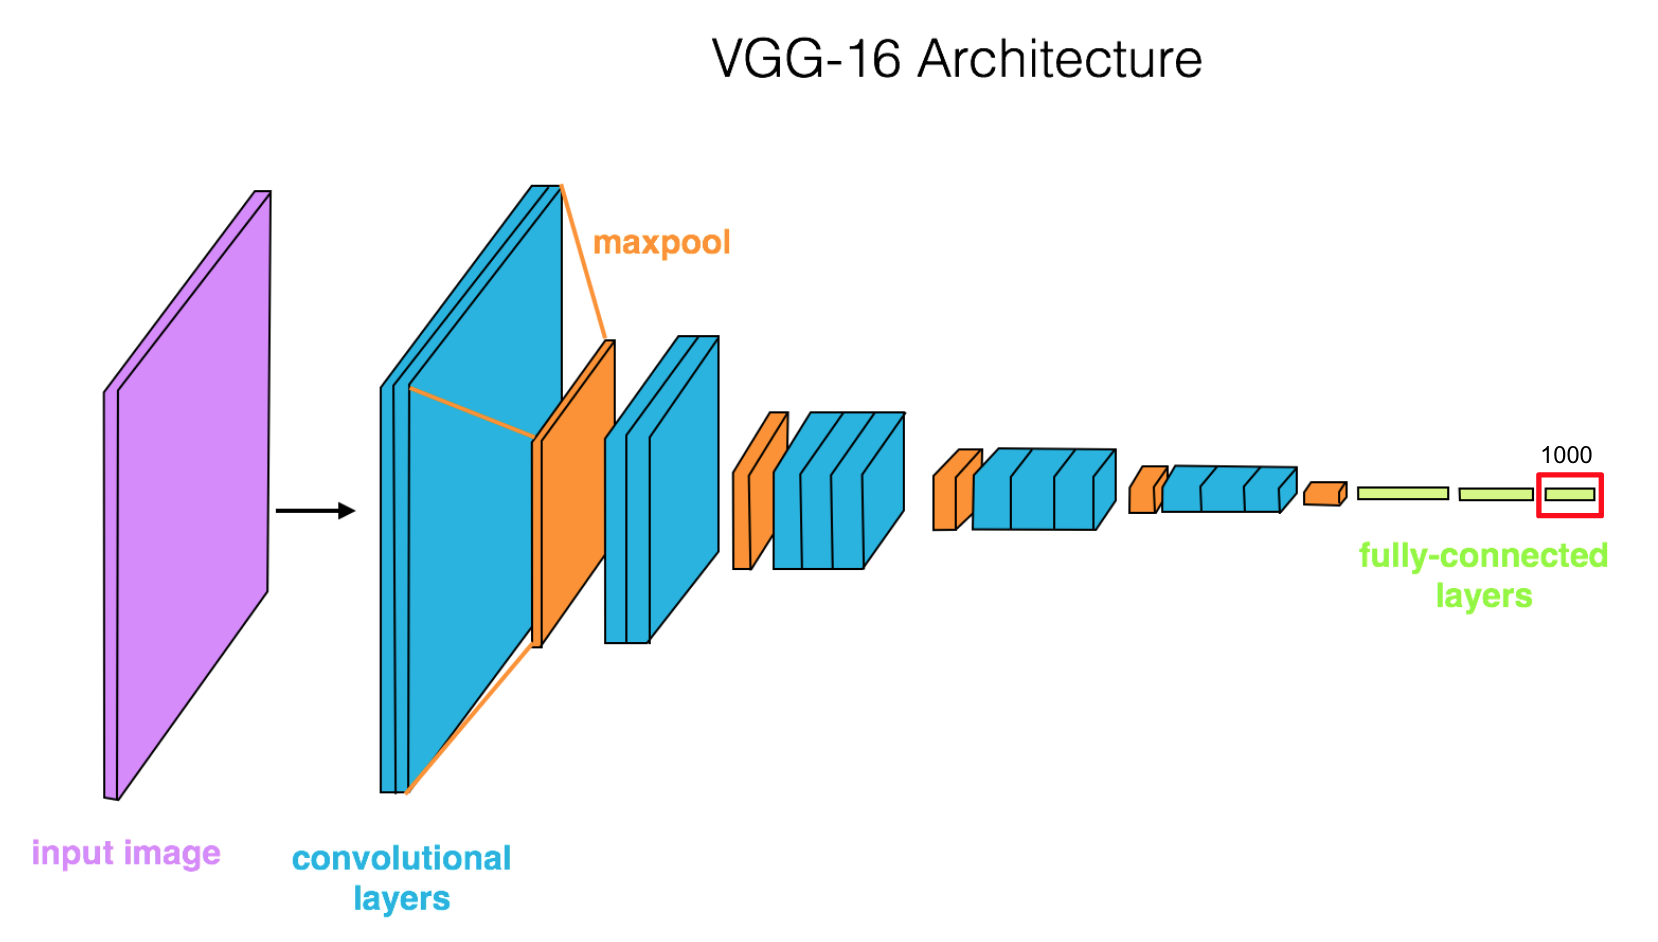

VGGNet is great because it's simple and has great performance, coming in second in the ImageNet competition. The idea here is that we keep all the convolutional layers, but replace the final fully-connected layer with our own classifier. This way we can use VGGNet as a fixed feature extractor for our images then easily train a simple classifier on top of that.

- Use all but the last fully-connected layer as a fixed feature extractor.

- Define a new, final classification layer and apply it to a task of our choice!

In [ ]:
# imports 

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

## **Load and Transform our Data**

In [ ]:
# define training and test data directories
data_dir = 'flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

### Transforming the Data

In [ ]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

### DataLoaders and Data Visualization

In [ ]:
# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

In [ ]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## **Define the Model**

To define a model for training we'll follow these steps:

1. Load in a pre-trained VGG16 model
2. "Freeze" all the parameters, so the net acts as a fixed feature extractor
3. Remove the last layer
4. Replace the last layer with a linear classifier of our own

In [ ]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

In [ ]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features)

In [ ]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

### Final Classifier Layer

Once you have the pre-trained feature extractor, you just need to modify and/or add to the final, fully-connected classifier layers. In this case, we suggest that you repace the last layer in the vgg classifier group of layers.

  - This layer should see as input the number of features produced by the portion of the network that you are not changing, and produce an appropriate number of outputs for the flower classification task.

In [ ]:
n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)

In [ ]:
print(vgg16)

### Specify Loss Function and Optimizer

In [ ]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

### Training

In [ ]:
# number of epochs to train the model
n_epochs = 5

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

### Testing

In [ ]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

### Visualize Sample Test Results

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx].cpu(), (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

### E para carrear uma nova imagem?

Use o seu modelo treinado, passe a imagem pela rede realizndo os mesmos procedimentos anteriores e veja a resposta.

#### Salvando a rede

A função a seguir salva os pesos da rede de acordo a sua estrutura 

In [ ]:
torch.save(vgg16.state_dict(), 'vgg16_model.pt')

#### E para usar o modelo salvo?

Carregue a estrutura da sua rede, após isso carregue os pesos salvos.

In [ ]:
# Carregando a estrutura
model = models.vgg16()

# Ajustando a última camada para o nosso problema
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer

# Carregando de fato os pesos salvos
model.load_state_dict(torch.load('vgg16_model.pt'))

model = model.cuda()

model.eval()

#### Baixando uma imagem de tulipa

In [ ]:
!wget -O tulipas.jpg https://www.dropbox.com/s/u9798t3vsn4lkfn/tulipas.jpg?dl=0

In [ ]:
# Carregando imagem
img = Image.open('tulipas.jpg')

In [ ]:
plt.imshow(img)

In [ ]:
# Convertendo imagem
img_tensor = data_transform(img).float()

img_tensor = Variable(img_tensor)

img_tensor = img_tensor.unsqueeze(0)

img_tensor = img_tensor.cuda()

print(f'Imagem original: {np.shape(img)}')
print(f'Imagem como tensor: {img_tensor.shape}')

In [ ]:
# Passar a imagem pela rede e verificar a predição
output = model(img_tensor)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)

In [ ]:
# Resultado
preds_tensor

In [ ]:
# transformar o resultdo em array
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

print(preds)

In [ ]:
prob = F.softmax(output, 1).data[0][preds].item()*100

print(prob)

In [ ]:
print(f'Imagem classificada como: {classes[preds]} com {prob:.4f}% de certeza')

### Mostrando a classificação na imagem com opencv

In [ ]:
img_array = np.array(img)
img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

img_array = cv2.putText(img_array, f'Imagem classificada como: {classes[preds]} com {prob:.4f}% de certeza', 
                        (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 1, cv2.LINE_AA)

cv2_imshow(np.array(img_array))